<h1><center>Box Plot</center></h1><br />

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime as dt
from matplotlib.dates import DateFormatter, MonthLocator, DayLocator
import seaborn as sns
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
from textwrap import fill
from matplotlib.ticker import FormatStrFormatter
from operator import add
# could also use holoview: http://holoviews.org/

In [3]:
list_csv_file = []
for i in range(30, 60):
    list_csv_file.append("Results_model_run%s.csv" % i)
list_dataframe = []
for filename in list_csv_file:
    list_dataframe.append(pd.read_csv(filename))
merged_dataframes = pd.concat(list_dataframe)
merged_dataframes['Cumulative PV capacity'] = (merged_dataframes['Total product']) / 1E9
merged_dataframes['Repaired eol PV modules'] = (merged_dataframes['eol - new repaired weight'] + 
                                 merged_dataframes['eol - used repaired weight']) / 1E9
merged_dataframes['Sold eol PV modules'] = (merged_dataframes['eol - new sold weight'] + 
                                 merged_dataframes['eol - used sold weight']) / 1E9
merged_dataframes['Recycled eol PV modules'] = (merged_dataframes['eol - new recycled weight'] + 
                                 merged_dataframes['eol - used recycled weight']) / 1E9 #* 0.8036 # baseline=0.8036 
                                                                                                 # frelp=0.9685
merged_dataframes['Landfilled eol PV modules'] = (merged_dataframes['eol - new landfilled weight'] + 
                                 merged_dataframes['eol - used landfilled weight']) / 1E9 #+ (
    #(1 - 0.8036) * merged_dataframes['Recycled eol PV modules']) # baseline=0.8036 frelp=0.9685
merged_dataframes['Stored eol PV modules'] = (merged_dataframes['eol - new stored weight'] + 
                                 merged_dataframes['eol - used stored weight']) / 1E9
merged_dataframes['% recycled'] = merged_dataframes['Recycled eol PV modules'] / (
    merged_dataframes['Repaired eol PV modules'] + merged_dataframes['Sold eol PV modules'] + 
    merged_dataframes['Recycled eol PV modules'] + merged_dataframes['Landfilled eol PV modules'] + 
    merged_dataframes['Stored eol PV modules'])
merged_dataframes['% reused'] = (merged_dataframes['Sold eol PV modules'] + 
                                 merged_dataframes['Repaired eol PV modules']) / (
    merged_dataframes['Repaired eol PV modules'] + merged_dataframes['Sold eol PV modules'] + 
    merged_dataframes['Recycled eol PV modules'] + merged_dataframes['Landfilled eol PV modules'] + 
    merged_dataframes['Stored eol PV modules'])
merged_dataframes['% CE'] = merged_dataframes['% recycled'] + merged_dataframes['% reused']
merged_dataframes["volume_recycled"] = (merged_dataframes["eol - new recycled weight"] + 
                                        merged_dataframes["eol - used recycled weight"])
merged_dataframes['Cumulative modules'] = (
    merged_dataframes['End-of-life - recycled'] / 235.2)
merged_dataframes['Yearly modules'] = merged_dataframes[
    'Cumulative modules'].sub(merged_dataframes['Cumulative modules'].shift())
# Wp/module = 235.2 (considered constant), Frelp recovery revenue = 0.456647 $/kg, asu = 0.404126, baseline = 0.196257
merged_dataframes['Net income ($/module)'] = (-1 * merged_dataframes['Recycler costs'] / 
                                              merged_dataframes['Cumulative modules'])
merged_dataframes.loc[~np.isfinite(merged_dataframes['Net income ($/module)']), 'Net income ($/module)'] = 0
merged_dataframes = merged_dataframes.groupby(['Year']).mean()
merged_dataframes['Yearly modules'].iloc[0] = merged_dataframes['Cumulative modules'].iloc[0]
merged_dataframes['Net income ($/module)'].iloc[0] = 0
merged_dataframes['Net income'] = merged_dataframes['Yearly modules'] * merged_dataframes['Net income ($/module)']
merged_dataframes['Cumulative net income'] = merged_dataframes['Net income'].cumsum()
merged_dataframes = merged_dataframes.filter([
    'Year', 'Repaired eol PV modules', 'Sold eol PV modules', 'Recycled eol PV modules', 
    'Landfilled eol PV modules', 'Stored eol PV modules', 'Cumulative PV capacity', 
    'volume_recycled', 'Recycled material volume', 'Net income ($/module)', 
    'Cumulative modules', 'Yearly modules', 'Net income', 'Cumulative net income', '% CE', '% recycled', 
    '% reused', 'Average recycling cost'], axis=1)
merged_dataframes.to_csv("MergedData.csv")
#print(merged_dataframes['Cumulative net income (without recycling fee)'])

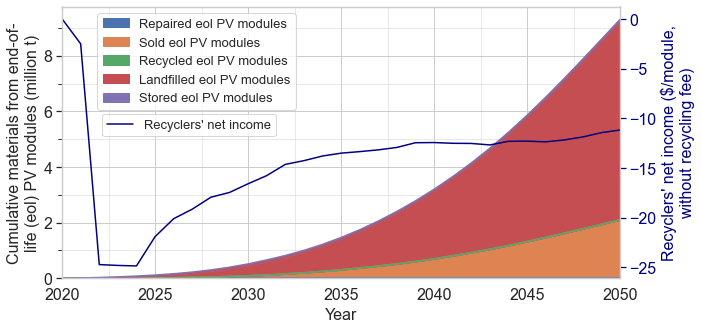

In [10]:
sns.set(style="whitegrid", color_codes=True)
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#rcParams['figure.figsize'] = 15, 5
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)

from textwrap import wrap
labels=['Cumulative materials from end-of-life (eol) PV modules (million t)', 
        "Recyclers' net income ($/module, without recycling fee)"]
labels = [ '\n'.join(wrap(l, 35)) for l in labels ]
label2=["Recyclers' net income"]
label2 = [ '\n'.join(wrap(l, 30)) for l in label2 ]

ax  = merged_dataframes.drop(columns=['Cumulative PV capacity', 
                                      'volume_recycled', 'Recycled material volume', 
                                      "Net income ($/module)", 'Cumulative modules', 'Yearly modules', 
                                      'Net income', 'Cumulative net income', '% CE', '% recycled', 
                                      '% reused', 'Average recycling cost']).plot.area()
ax.plot()
ax.set_ylabel(labels[0], wrap=True)
#ax.set_ylim(top=10)
ax2 = ax.twinx()
ax2  = merged_dataframes['Net income ($/module)'].plot.line(label=label2[0], color='navy')
ax2.plot()
ax2.yaxis.label.set_color('navy')
ax2.tick_params(axis='y', colors='navy')
ax2.set_ylabel(labels[1], wrap=True)
ax2.grid(b=None)
#ax2.axis('off')
#ax2.set_ylim(top=600)
#plt.stackplot(merged_dataframes['Year'],, labels=['A','B','C'])
ax.legend(bbox_to_anchor=(0.43, 1), fontsize=13)
ax2.legend(bbox_to_anchor=(0.06, 0.63), fontsize=13)
import matplotlib as mpl
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.grid(b=True, which='minor', color='lightgrey', linewidth=0.5)
plt.savefig("figure10.2.png", bbox_inches='tight', figsize=(5.5, 3.5), dpi=500)